In [3]:
import sys
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import os
import glob
import pickle
from time import time
from time import strftime
from collections import OrderedDict
from importlib import reload
import random 

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
import scipy.signal as signal
import statsmodels.api as sm
import astropy.stats.circstats as circstats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
#from cluster_helper.cluster import cluster_view
from ptsa.data.TimeSeriesX import TimeSeries 
#from ptsa.data.filters import MorletWaveletFilter
from ptsa.data.filters import ButterworthFilter
#from ptsa.data.filters import MonopolarToBipolarMapper
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace

In [4]:
## Setup project.
dirs, subj_info, config, subj_df, subj_df_file = manning_analysis.setup_session()
proj_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
data_dir = dirs['data']
figure_dir = dirs['figs']
ccg_dir = '/scratch/dscho/unit_activity_and_hpc_theta'
spikes_dir = '/scratch/dscho/unit_activity_and_hpc_theta/data/spikes'

# Figure out which subjects have dataframes in metadata.
files = glob.glob(os.path.join(data_dir, 'metadata', 'subj_df_*.xlsx'))
subj_df = pd.read_excel(files[0], converters={'chan': str})
for f in files[1:]:
    subj_df = subj_df.append(pd.read_excel(f, converters={'chan': str}))
subj_df = subj_df.loc[subj_df.location!='none']
subj_df = subj_df.loc[subj_df.subj_sess != 'U367_env2']

# Get a dictionary of all channels with 1+ units.
spike_chans = OrderedDict(subj_df.loc[subj_df.n_clusters>0][['subj_sess', 'chan']].groupby('subj_sess').chan.apply(list))

# Get kept channels.
with open(os.path.join(data_dir, 'other', 'keep_chans.pkl'), 'rb') as f:
    keep_chans = pickle.load(f)
sessions = sorted(keep_chans.keys())

# Get unit pairs.
with open(os.path.join(spikes_dir, 'unit_pairs_df.pkl'), 'rb') as f:
    unit_pairs_df = pickle.load(f)   
    
# Add these columns if they don't exist.    
for subj_sess in sorted(unit_pairs_df.keys()):
    unit_pairs_df[subj_sess].insert(0, 'unit_pair', unit_pairs_df[subj_sess].unit1.map(str) + '_' + unit_pairs_df[subj_sess].unit2.map(str))
    unit_pairs_df[subj_sess].insert(0, 'subj_sess', subj_sess)
    
print('{} sessions'.format(len(sessions)))

Loading subjects DataFrame: /data3/scratch/dscho/frLfp/data/subj_df.xlsx

There are 20 subjects, 46 sessions, and 2944 channels in the study.

46 sessions will be processed: ['U367_env2', 'U369_env1', 'U369_env2', 'U370_env1', 'U371_env1', 'U371_env2', 'U371_env3', 'U372_ses1', 'U372_ses2', 'U373_ses1', 'U373_ses2', 'U373_ses3', 'U374_ses1', 'U374_ses2', 'U379_ses1', 'U380_ses1a', 'U380_ses2', 'U380_ses3', 'U381_ses1', 'U381_ses2', 'U381_ses3', 'U384_ses1', 'U384_ses2', 'U384_ses3', 'U385_ses1', 'U385_ses2', 'U385_ses3', 'U385_ses4', 'U386_ses1', 'U386_ses2', 'U387_ses1', 'U387_ses2', 'U387_ses3', 'U390_ses1', 'U390_ses2', 'U390_ses3', 'U390_ses4', 'U392_ses1', 'U393_ses2', 'U394_ses1', 'U394_ses3', 'U395_ses1', 'U395_ses2', 'U395_ses3', 'U396_ses2', 'U396_ses3']
0 sessions have missing input files and will not be processed.

46 sessions


In [7]:
[x for x in sessions if (x!='U367_env2') & (x not in missing_subjs)]

NameError: name 'missing_subjs' is not defined

In [20]:
[f for f in files if f[-13:-4] in sessions_subset]

['/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U372_ses1.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U369_env2.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U370_env1.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U372_ses2.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U373_ses2.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U373_ses3.pkl',
 '/scratch/dscho/unit_activity_and_hpc_theta/data/phase_locking/local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_U369_env1.pkl',
 '/scratch/dscho/uni

In [42]:
# Upload local phase-locking results
# freqs = np.array([2**(x/8) for x in range(54)])
# files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_jacobs-methods_50freq1-100Hz_pow0mask_interp-2_8ms_*.pkl'))

# freqs = np.array([f for f in np.logspace(np.log10(0.1), np.log10(500), 62) if (abs(60 - f) > 5) 
#                  and (abs(120 - f) > 5) and (abs(180 - f) > 5)])
# files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_60freq0-499Hz_pow25mask_interp-2_4ms_*.pkl'))

# freqs = np.logspace(np.log10(1), np.log10(10), 20)
# files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_nonotch_20freq1-10Hz_pow0mask_interp-2_4ms_*.pkl'))

# freqs = np.array([f for f in np.logspace(np.log10(1), np.log10(100), 52) if abs(60 - f) > 5])
# files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_50freq1-100Hz_pow25mask_interp-2_4ms_*.pkl'))

freqs = np.array([f for f in np.logspace(np.log10(1), np.log10(200), 53) if (abs(60 - f) > 5) and (abs(120 - f) > 5) and (abs(180 - f) > 5)])
files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_50freq1-200Hz_pow25mask_interp-2_4ms_*.pkl'))

# freqs = np.array([f for f in np.logspace(np.log10(1), np.log10(200), 53) if (abs(60 - f) > 5) and (abs(120 - f) > 5) and (abs(180 - f) > 5)])
# files = glob.glob(os.path.join(ccg_dir, 'data', 'phase_locking', 'local_phase_locking_df_50freq1-200Hz_pow90mask_interp-2_4ms_*.pkl'))

# Select a random third of sessions.
missing_subjs = [subj_sess for subj_sess in sessions if subj_sess not in [f[-13:-4] for f in files]]
sessions_ = [x for x in sessions if (x!='U367_env2') & (x not in missing_subjs)]
v = np.arange(len(sessions_))
np.random.shuffle(v)
sessions_subset = np.array(sessions_)[v[:int(round(len(v)/3, 0))]]
files_ = [f for f in files if f[-13:-4] in sessions_subset]

print('{} sessions in subset:\n{}'.format(len(files_), sessions_subset))

14 sessions in subset:
['U387_ses3' 'U369_env1' 'U372_ses2' 'U390_ses3' 'U369_env2' 'U373_ses1'
 'U387_ses1' 'U380_ses2' 'U393_ses2' 'U395_ses2' 'U384_ses3' 'U385_ses4'
 'U371_env2' 'U371_env3']


In [43]:
# Load phase-locking data.
alpha = 0.05
bonf_alpha = max(0.001, 0.05 / len(freqs))
print('Alpha: {}; Bonferroni-corrected alpha: {}'.format(alpha, round(bonf_alpha, 4)))

for i, fi in enumerate(files_):
    with open(fi, 'rb') as f:
        if i == 0:
            pl_df = pickle.load(f)
        else:
            pl_df = pl_df.append(pickle.load(f))  
pl_df.reset_index(drop=True, inplace=True)
pl_df['bs_pvals'] = pl_df.pval_inds_1000.apply(lambda x: (x+1)/1001)
pl_df['sig'] = pl_df.pvals.apply(lambda x: np.any(x < bonf_alpha))
pl_df['sigs'] = pl_df.pvals.apply(lambda x: x < bonf_alpha)
pl_df['bs_sig'] = pl_df.bs_pvals.apply(lambda x: np.any(x < bonf_alpha))
pl_df['bs_sigs'] = pl_df.bs_pvals.apply(lambda x: x < bonf_alpha)
pl_df['pval_argmin'] = pl_df.pvals.apply(lambda x: np.argmin(x))
pl_df['circmom_argmax'] = pl_df.circmoms.apply(lambda x: np.argmax(x))
pl_df['kappa_argmax'] = pl_df.kappas.apply(lambda x: np.argmax(x))

sig_type_single = 'pval_argmin' # pval_argmin, circmom_argmax, or kappa_argmax
sig_type_multi = 'bs_sigs' # sigs or bs_sigs

locked_freqs = []
locked_phases = []
locked_circmoms = []
locked_kappas = []
locked_pvals = []
for i in range(len(pl_df)):
    locked_freqs.append(freqs[pl_df.at[i, sig_type_single]])
    locked_phases.append(pl_df.at[i, 'mus'][pl_df.at[i, sig_type_single]])
    locked_circmoms.append(pl_df.at[i, 'circmoms'][pl_df.at[i, sig_type_single]])
    locked_kappas.append(pl_df.at[i, 'kappas'][pl_df.at[i, sig_type_single]])
    locked_pvals.append(pl_df.at[i, 'pvals'][pl_df.at[i, sig_type_single]])
pl_df['locked_freq'] = np.array(locked_freqs)
pl_df['locked_phase'] = np.array(locked_phases)
pl_df['locked_circmom'] = np.array(locked_circmoms)
pl_df['locked_kappa'] = np.array(locked_kappas)
pl_df['locked_pval'] = np.array(locked_pvals)

locked_freqs = []
locked_phases = []
locked_circmoms = []
locked_kappas = []
locked_pvals = []
for i in range(len(pl_df)):
    locked_freqs.append(freqs[pl_df.at[i, sig_type_multi]])
    locked_phases.append(pl_df.at[i, 'mus'][pl_df.at[i, sig_type_multi]])
    locked_circmoms.append(pl_df.at[i, 'circmoms'][pl_df.at[i, sig_type_multi]])
    locked_kappas.append(pl_df.at[i, 'kappas'][pl_df.at[i, sig_type_multi]])
    locked_pvals.append(pl_df.at[i, 'pvals'][pl_df.at[i, sig_type_multi]])
pl_df['locked_freqs'] = np.array(locked_freqs)
pl_df['locked_phases'] = np.array(locked_phases)
pl_df['locked_circmoms'] = np.array(locked_circmoms)
pl_df['locked_kappas'] = np.array(locked_kappas)
pl_df['locked_pvals'] = np.array(locked_pvals)
pl_df['n_locked'] = pl_df.locked_pvals.apply(lambda x: len(x))

sig_type = 'bs_sig' # sig or bs_sig
pl_df_sig = pl_df.query("({} == True)".format(sig_type))

Alpha: 0.05; Bonferroni-corrected alpha: 0.001


In [44]:
missing_subjs

['U380_ses1a', 'U390_ses4']

In [45]:
pl_df.columns

Index(['subj_sess', 'unit', 'chan', 'hem', 'roi', 'hemroi', 'is_hpc', 'phases',
       'mus', 'kappas', 'circmoms', 'pvals', 'pval_inds_1000', 'bs_pvals',
       'sig', 'sigs', 'bs_sig', 'bs_sigs', 'pval_argmin', 'circmom_argmax',
       'kappa_argmax', 'locked_freq', 'locked_phase', 'locked_circmom',
       'locked_kappa', 'locked_pval', 'locked_freqs', 'locked_phases',
       'locked_circmoms', 'locked_kappas', 'locked_pvals', 'n_locked'],
      dtype='object')

In [46]:
stats.pearsonr(list(pl_df_sig.pval_argmin), list(pl_df_sig.circmom_argmax))

(0.9279948690525152, 2.1405704783837258e-226)

In [47]:
# What percent of units are phase-locked to any frequency?
n_locked_thresh = len(freqs) + 1
print(len(pl_df.query("(sig==True)")) / len(pl_df), 
      len(pl_df.query("(bs_sig==True)")) / len(pl_df))

0.8502340093603744 0.8190327613104524


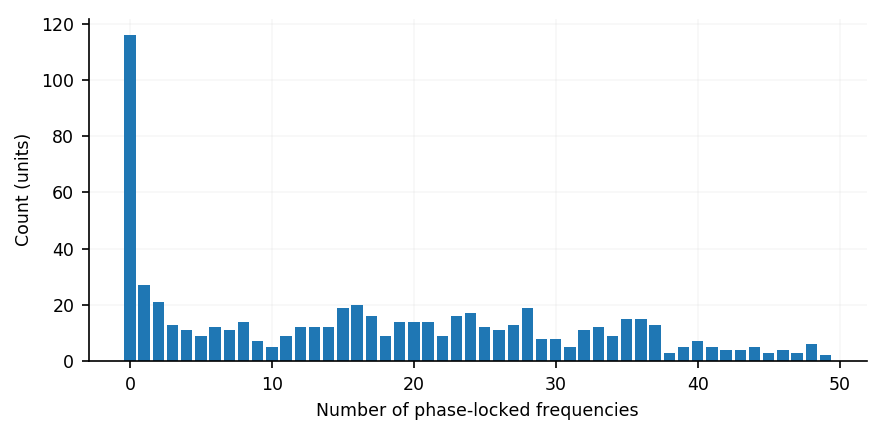

In [48]:
# How many frequencies is each unit phase-locked to? 
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=150)
ax = np.ravel(ax)

ax[0].bar(pl_df.groupby('n_locked').sig.count().index.tolist(), pl_df.groupby('n_locked').sig.count().tolist())
#ax[0].bar(pl_df.groupby('n_locked').bs_sig.count().index.tolist(), pl_df.groupby('n_locked').bs_sig.count().tolist())
ax[0].set_xticks([int(x) for x in np.linspace(0, len(freqs), 6)])
ax[0].set_xlabel('Number of phase-locked frequencies')
ax[0].set_ylabel('Count (units)')
fig.tight_layout()

In [49]:
# How many of each neuron type do we have (sig, total)?
print('Hippocampus: ', len(pl_df.query("(is_hpc==True) & (bs_sig==True)")),
      len(pl_df.query("(is_hpc==True)")))
print('Parahippocampal: ', len(pl_df.query("(is_hpc==False) & (roi==['EC', 'PG']) & (bs_sig==True)")), 
      len(pl_df.query("(is_hpc==False) & (roi==['EC', 'PG'])")))
print('Amygdala: ', len(pl_df.query("(is_hpc==False) & (roi==['A']) & (bs_sig==True)")),
      len(pl_df.query("(is_hpc==False) & (roi==['A'])")))
print('Frontal: ', len(pl_df.query("(is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (bs_sig==True)")),
      len(pl_df.query("(is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA'])")))
print('Cortex (Other): ', len(pl_df.query("(is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (bs_sig==True)")),
      len(pl_df.query("(is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA'])")))

Hippocampus:  109 138
Parahippocampal:  143 163
Amygdala:  116 149
Frontal:  53 69
Cortex (Other):  104 122


In [50]:
df = OrderedDict()
total = 0
rois = ['hpc', 'phpc', 'amg', 'fl', 'ctx']
fancy_names = {'hpc': 'Hippocampus', 
               'phpc': 'Parahippocampal', 
               'amg': 'Amygdala', 
               'fl': 'Frontal', 
               'ctx': 'Cortex (Other)'}
df['hpc'] = pl_df.query("({}==True) & (is_hpc==True)".format(sig_type))
df['phpc'] = pl_df.query("({}==True) & (is_hpc==False) & (roi==['EC', 'PG'])".format(sig_type))
df['amg'] = pl_df.query("({}==True) & (is_hpc==False) & (roi=='A')".format(sig_type))
df['fl'] = pl_df.query("({}==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA'])".format(sig_type))
df['ctx'] = pl_df.query("({}==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA'])".format(sig_type))
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units'.format(total))

counts = {}
for roi in df.keys():
    od = OrderedDict(zip(freqs[np.unique(df[roi][sig_type_single], return_counts=True)[0]], 
                         np.unique(df[roi][sig_type_single], return_counts=True)[1]))
    for freq in freqs:
        if freq not in od:
            od[freq] = 0
    xsort = np.array(list(od.keys())).argsort()
    
    counts[roi] = OrderedDict(zip(np.array(list(od.keys()))[xsort], np.array(list(od.values()))[xsort]))

Hippocampus: 109 units
Parahippocampal: 143 units
Amygdala: 116 units
Frontal: 53 units
Cortex (Other): 104 units
525 phase-locked units


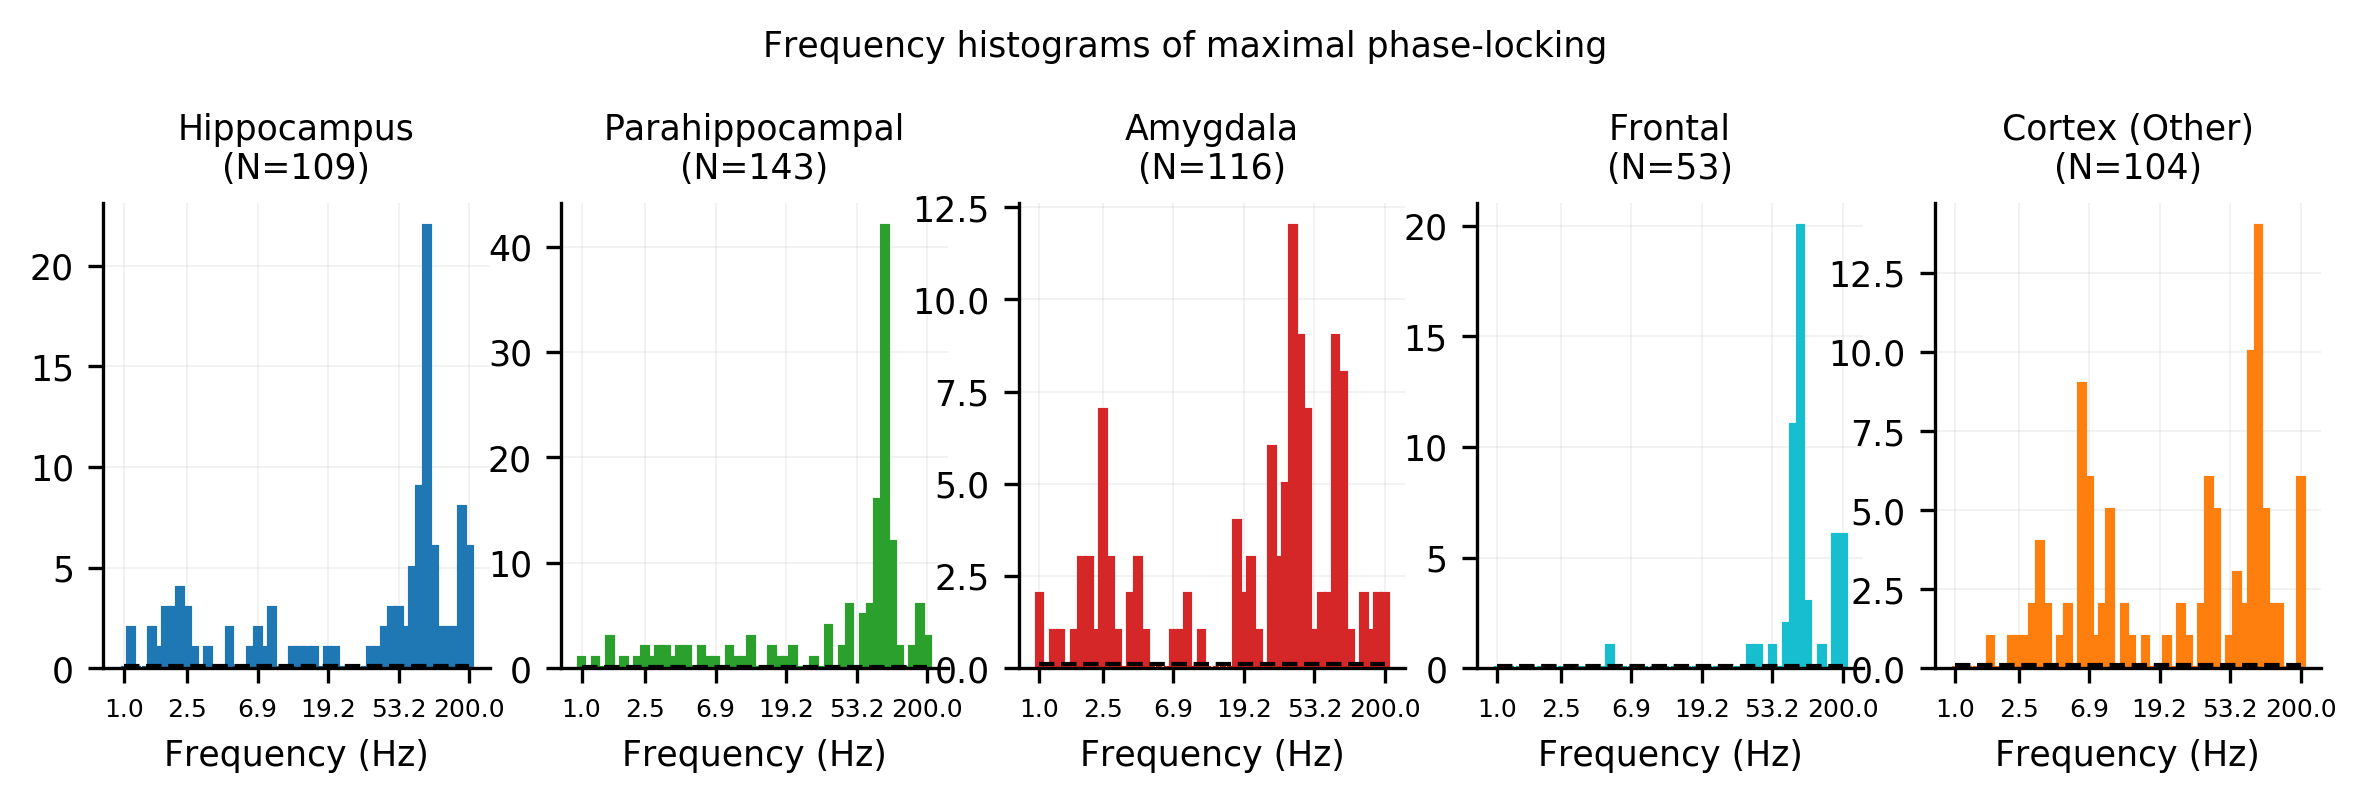

In [51]:
colors = ['C0', 'C2', 'C1', 'C9', 'C3']

fig, ax = plt.subplots(1, 5, figsize=(8, 2.5), dpi=300)
ax = np.ravel(ax)
exp_fp = bonf_alpha * len(df[roi]) # the expected number of false positive electrodes at each freqs

for i, roi in enumerate(rois):
    ax[i].bar(np.arange(len(freqs)), np.array(list(counts[roi].values())), 
              color=colors[i], edgecolor=colors[i])
    ax[i].plot(np.arange(len(freqs)), [exp_fp] * len(freqs), color='k', linestyle='--', linewidth=1)
    ax[i].set_xticks(np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int))
    ax[i].set_xticklabels([round(f, 1) for f in freqs[np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int)]], fontsize=6)
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_title('{}\n(N={})'.format(fancy_names[roi], np.sum(list(counts[roi].values()))))

fig.suptitle('Frequency histograms of maximal phase-locking', y=1.05)
fig.tight_layout(w_pad=-0.5, h_pad=0)

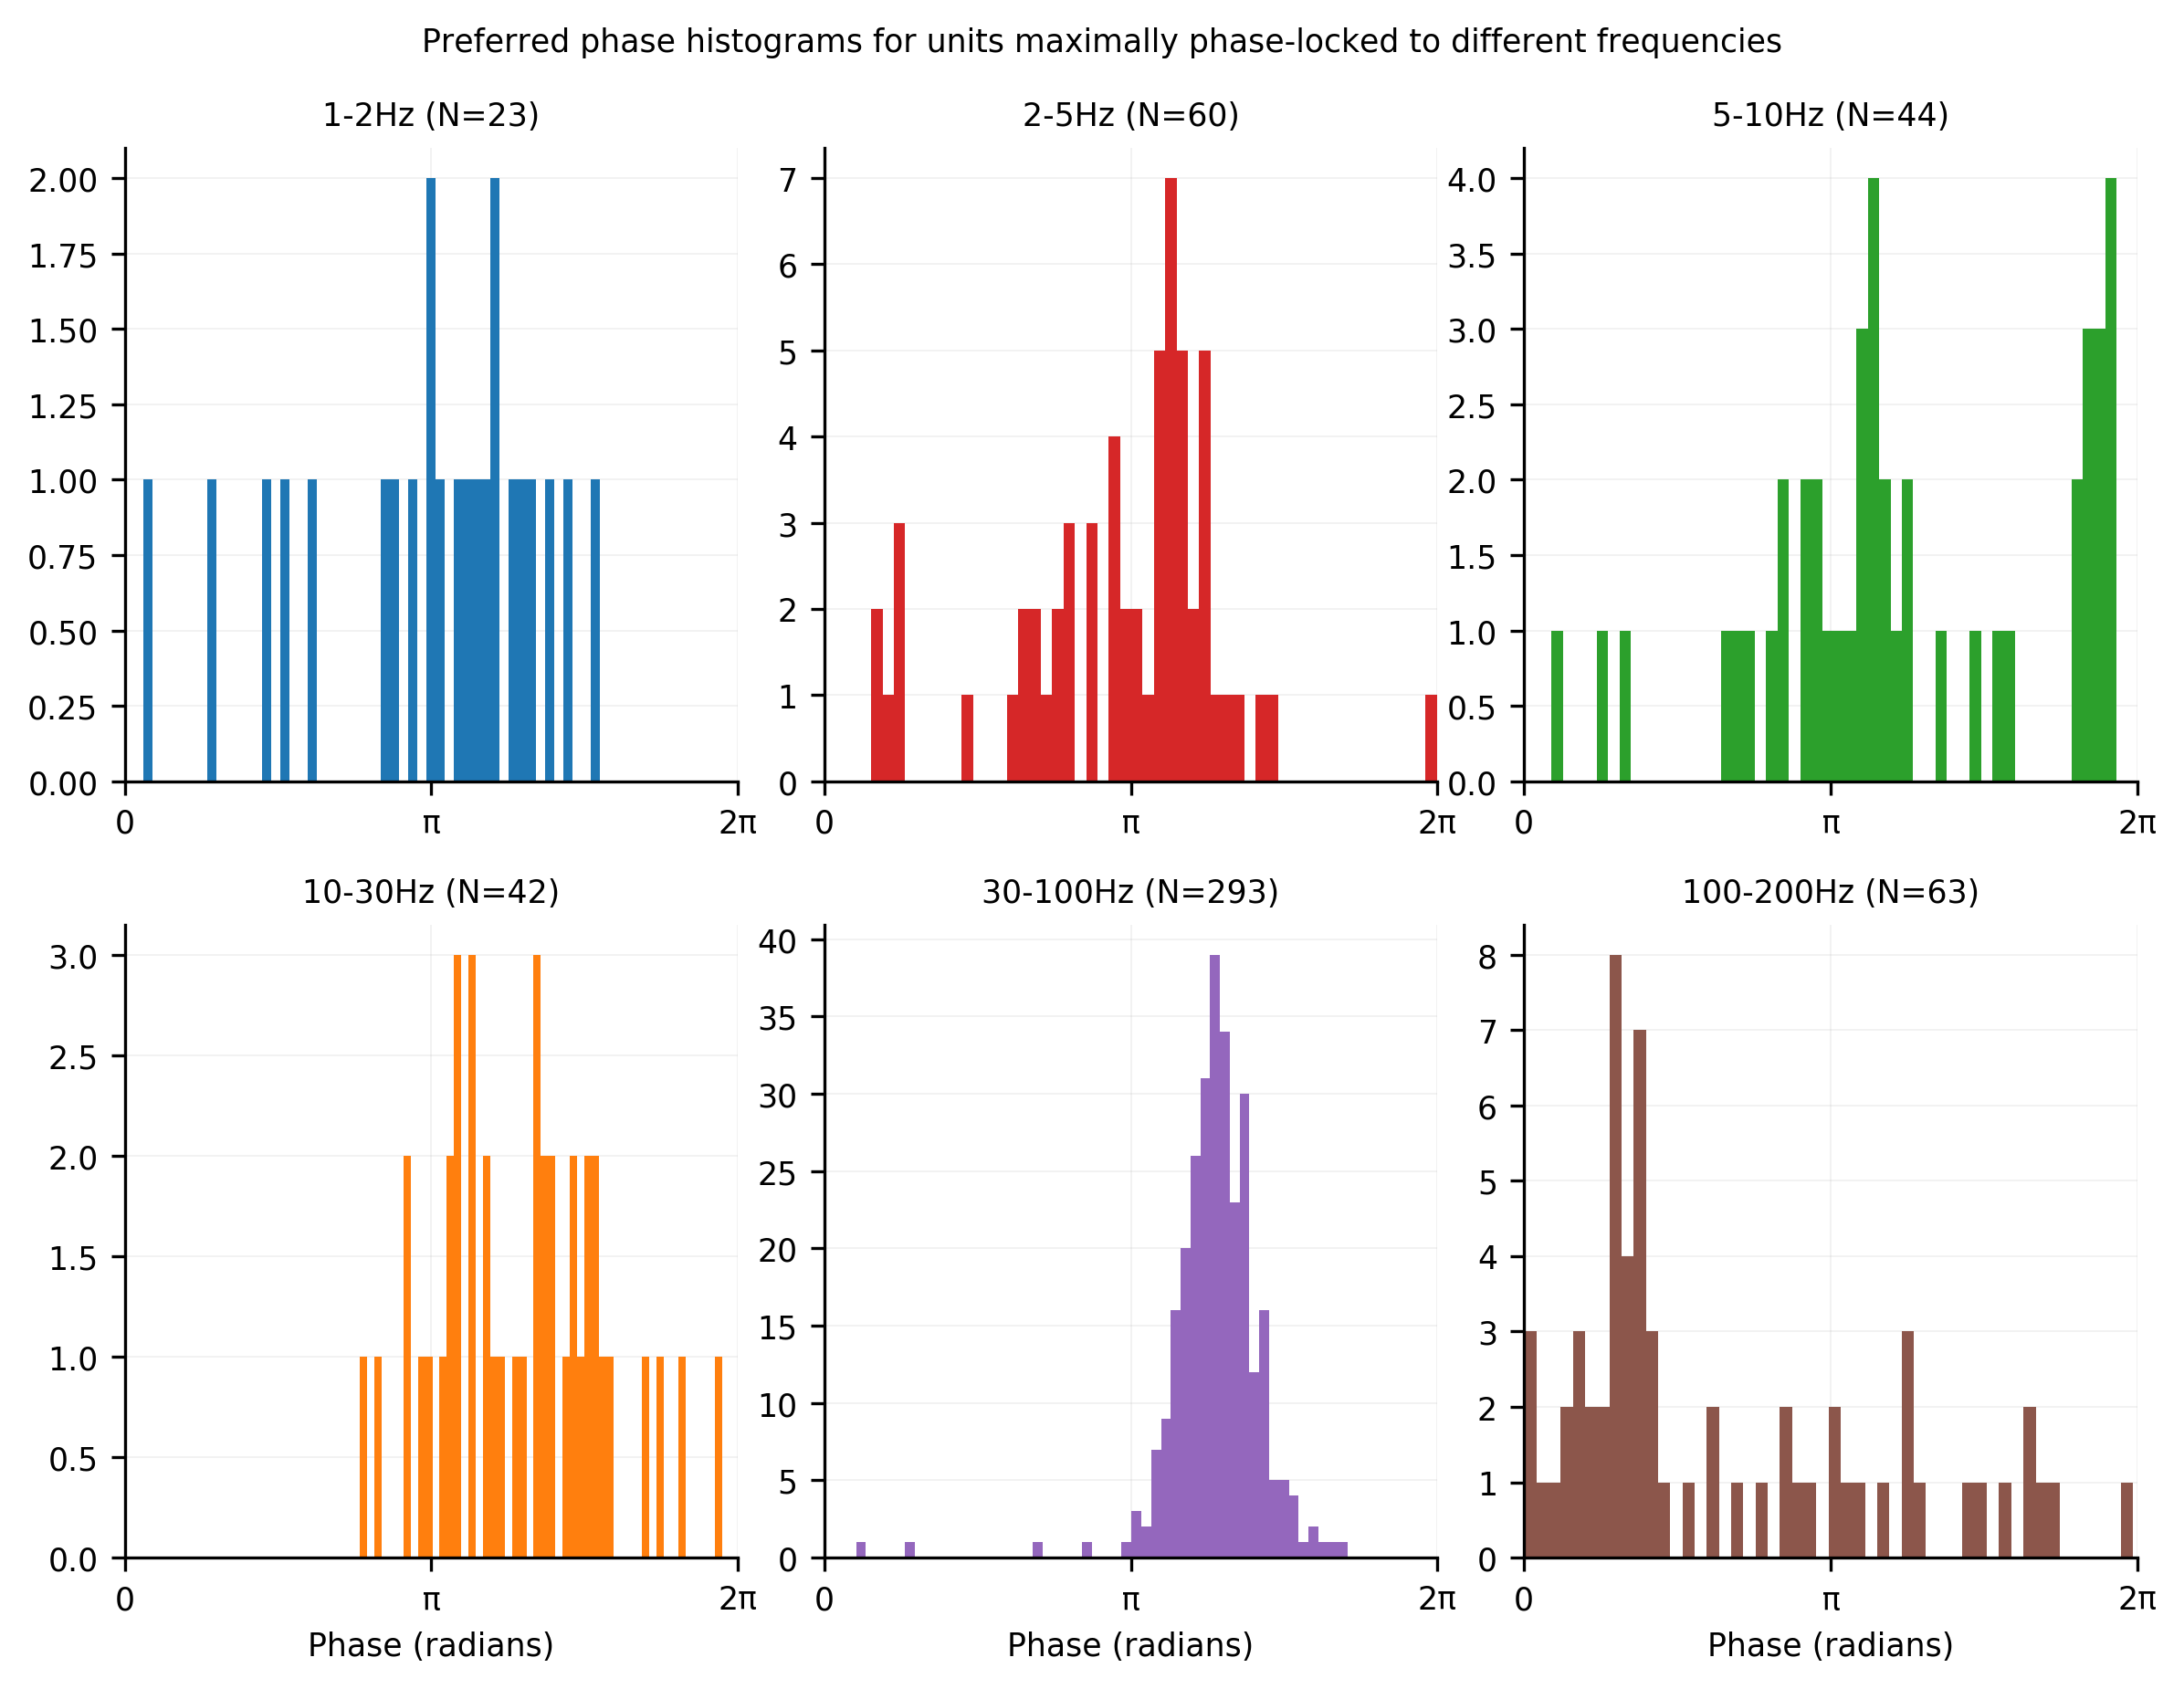

In [53]:
def convert_radians(vec):
    """Convert from -pi:pi to 0:2pi"""
    return (vec + (2*np.pi)) % (2*np.pi)

circmoms = np.array(pl_df.query("(bs_sig==True) & (n_locked<{})".format(n_locked_thresh)).locked_circmom.tolist())
mus_subdelta = convert_radians(np.array(pl_df.query("(bs_sig==True) & (locked_freq<2)").locked_phase.tolist()))
mus_lowtheta = convert_radians(np.array(pl_df.query("(bs_sig==True) & (2<locked_freq<=5)").locked_phase.tolist()))
mus_hightheta = convert_radians(np.array(pl_df.query("(bs_sig==True) & (5<locked_freq<=10)").locked_phase.tolist()))
mus_alphabeta = convert_radians(np.array(pl_df.query("(bs_sig==True) & (10<locked_freq<=30)").locked_phase.tolist()))
mus_lowgamma = convert_radians(np.array(pl_df.query("(bs_sig==True) & (30<locked_freq<=100)").locked_phase.tolist()))
mus_highgamma = convert_radians(np.array(pl_df.query("(bs_sig==True) & (100<locked_freq)").locked_phase.tolist()))
mus = [mus_subdelta, mus_lowtheta, mus_hightheta, mus_alphabeta, mus_lowgamma, mus_highgamma]
labels = ['1-2Hz', '2-5Hz', '5-10Hz', '10-30Hz', '30-100Hz', '100-200Hz']

fig, ax = plt.subplots(2, 3, sharex=False, figsize=(8, 6), dpi=300)
ax = np.ravel(ax)

for i in range(6):
    ax[i].hist(mus[i], bins=50, color='C{}'.format(i))
    ax[i].set_xlim([0, 2*np.pi])
    ax[i].set_xticks([0, np.pi, 2*np.pi])
    ax[i].set_xticklabels([0, 'π', '2π'])
    if i > 2:
        ax[i].set_xlabel('Phase (radians)')
    ax[i].set_title('{} (N={})'.format(labels[i], len(mus[i])))
    
fig.suptitle('Preferred phase histograms for units maximally phase-locked to different frequencies', y=1.02)
fig.tight_layout(w_pad=0, h_pad=1)

Median length of phase-locked unit: 0.1492083339338864


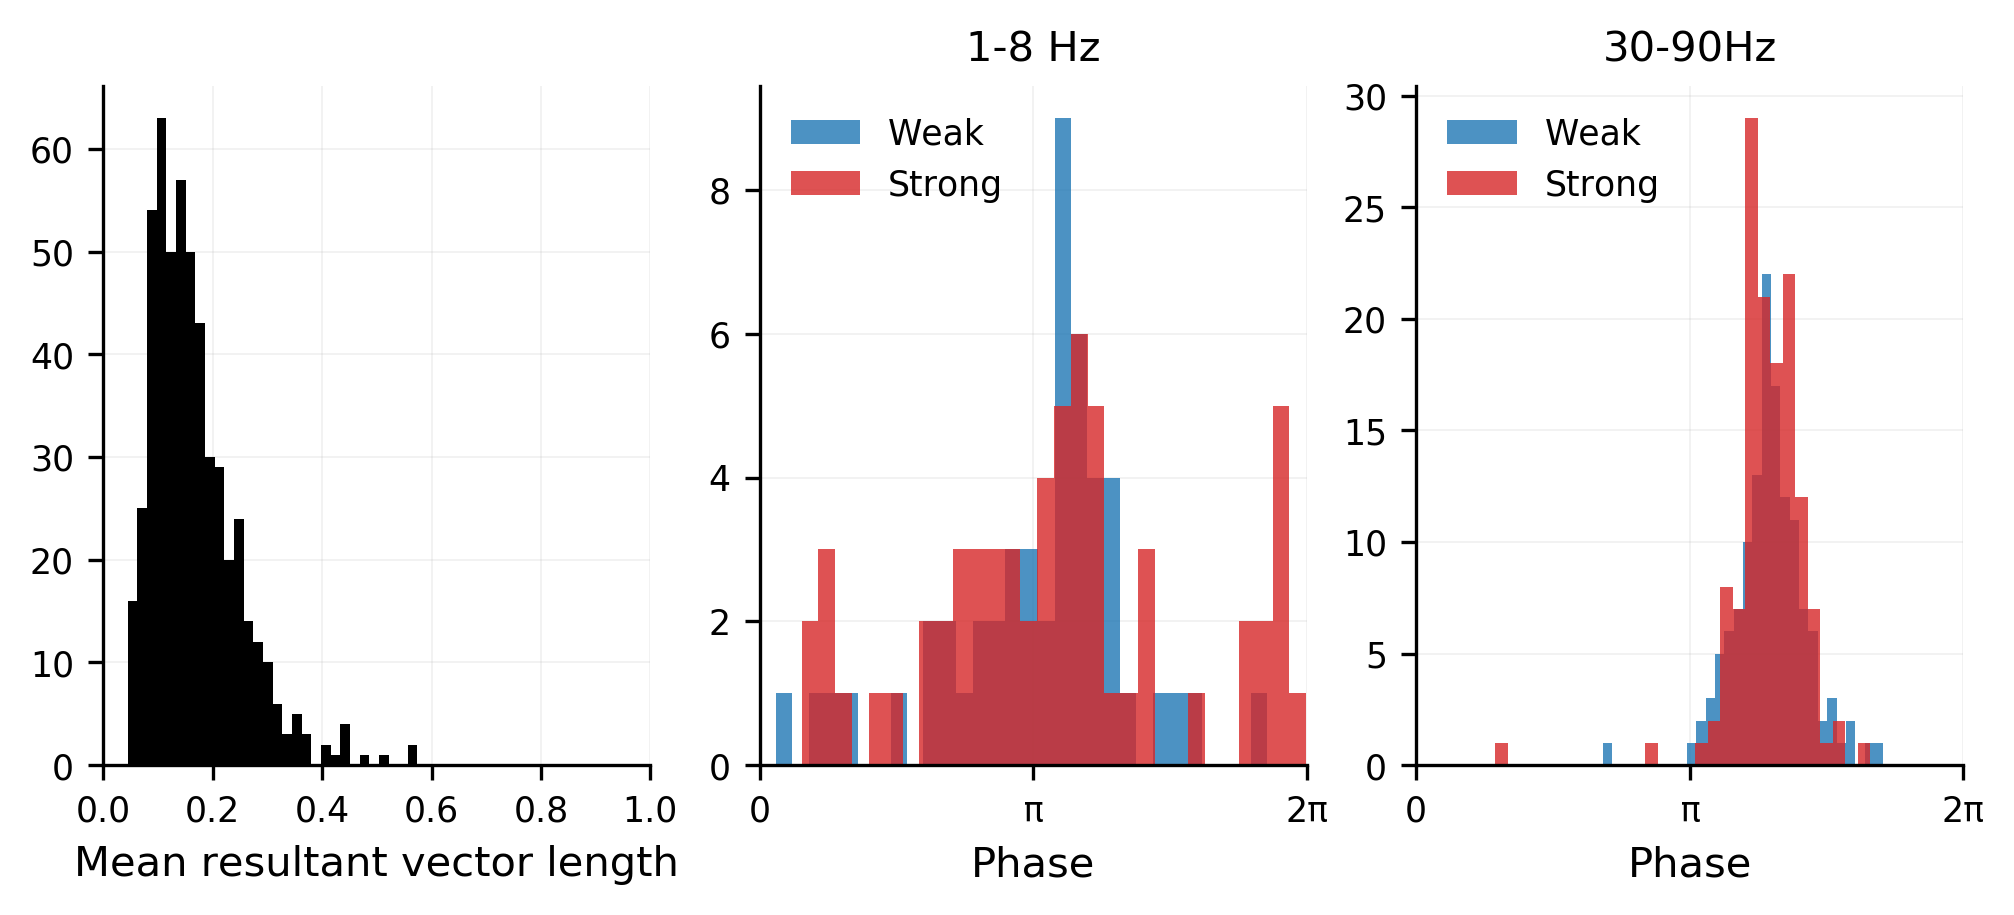

In [55]:
circmoms = np.array(pl_df.query("({}==True)".format(sig_type)).locked_circmom.tolist())
circmom_thresh = np.percentile(circmoms, 50)
print('Median length of phase-locked unit: {}'.format(circmom_thresh))
mus_theta_low = np.array(pl_df.query("(bs_sig==True) & (1<=locked_freq<=8) & (locked_circmom<={})".format(circmom_thresh)).locked_phase.tolist())
mus_theta_high = np.array(pl_df.query("(bs_sig==True) & (1<=locked_freq<=8) & (locked_circmom>{})".format(circmom_thresh)).locked_phase.tolist())
mus_gamma_low = np.array(pl_df.query("(bs_sig==True) & (30<=locked_freq<=90) & (locked_circmom<={})".format(circmom_thresh)).locked_phase.tolist())
mus_gamma_high = np.array(pl_df.query("(bs_sig==True) & (30<=locked_freq<=90) & (locked_circmom>{})".format(circmom_thresh)).locked_phase.tolist())
mus_theta_low = convert_radians(mus_theta_low)
mus_theta_high = convert_radians(mus_theta_high)
mus_gamma_low = convert_radians(mus_gamma_low)
mus_gamma_high = convert_radians(mus_gamma_high)

fig, ax = plt.subplots(1, 3, figsize=(8, 3), dpi=300)
ax = np.ravel(ax)

ax[0].hist(circmoms, bins=30, color='k')
ax[0].set_xlim([0, 1])
ax[0].set_xlabel('Mean resultant vector length', fontsize=10)

ax[1].hist(mus_theta_low, bins=30, color='C0', alpha=0.8, label='Weak')
ax[1].hist(mus_theta_high, bins=30, color='C1', alpha=0.8, label='Strong')
ax[1].set_xlim([0, 2*np.pi])
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([0, 'π', '2π'])
ax[1].set_xlabel('Phase', fontsize=10)
ax[1].set_title('1-8 Hz', fontsize=10)
ax[1].legend()

ax[2].hist(mus_gamma_low, bins=30, color='C0', alpha=0.8, label='Weak')
ax[2].hist(mus_gamma_high, bins=30, color='C1', alpha=0.8, label='Strong')
ax[2].set_xlim([0, 2*np.pi])
ax[2].set_xticks([0, np.pi, 2*np.pi])
ax[2].set_xticklabels([0, 'π', '2π'])
ax[2].set_xlabel('Phase', fontsize=10)
ax[2].set_title('30-90Hz', fontsize=10)
ax[2].legend()

In [61]:
# Here we will look at the depth of modulation (circmom) at
# each frequency among neurons phase-locked to any frequency
# i.e. circmoms are included at non-phase-locked frequencies as
# long as a unit is phase-locked to something.

rois = ['hpc', 'phpc', 'amg', 'fl', 'ctx']
fancy_names = {'hpc': 'Hippocampus', 
               'phpc': 'Parahippocampal', 
               'amg': 'Amygdala', 
               'fl': 'Frontal', 
               'ctx': 'Cortex (Other)'}

# All phase-locked units
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG'])")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A')")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA'])")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA'])")
print('All phase-locked units')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts3_all = {}
for roi in df.keys():
    circmoms = df[roi].circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(circmoms)):
        for ifreq in range(len(freqs)):
            od.setdefault(freqs[ifreq], []).append(circmoms[iunit][ifreq])
    counts3_all[roi] = OrderedDict(zip(np.array(list(od.keys())), np.array([np.mean(x) for x in list(od.values())])))

# Units maximally phase-locked to low (1-10Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (locked_freq<10)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (locked_freq<10)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (locked_freq<10)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (locked_freq<10)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (locked_freq<10)")
print('Low phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts3_low = {}
for roi in df.keys():
    circmoms = df[roi].circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(circmoms)):
        for ifreq in range(len(freqs)):
            od.setdefault(freqs[ifreq], []).append(circmoms[iunit][ifreq])
    counts3_low[roi] = OrderedDict(zip(np.array(list(od.keys())), np.array([np.mean(x) for x in list(od.values())])))

# Units maximally phase-locked to mid (10-30Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (10<locked_freq<30)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (10<locked_freq<30)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (10<locked_freq<30)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (10<locked_freq<30)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (10<locked_freq<30)")
print('Mid phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts3_mid = {}
for roi in df.keys():
    circmoms = df[roi].circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(circmoms)):
        for ifreq in range(len(freqs)):
            od.setdefault(freqs[ifreq], []).append(circmoms[iunit][ifreq])
    counts3_mid[roi] = OrderedDict(zip(np.array(list(od.keys())), np.array([np.mean(x) for x in list(od.values())])))
    
# Units maximally phase-locked to high (>30Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (locked_freq>30)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (locked_freq>30)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (locked_freq>30)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (locked_freq>30)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (locked_freq>30)")
print('High phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts3_high = {}
for roi in df.keys():
    circmoms = df[roi].circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(circmoms)):
        for ifreq in range(len(freqs)):
            od.setdefault(freqs[ifreq], []).append(circmoms[iunit][ifreq])
    counts3_high[roi] = OrderedDict(zip(np.array(list(od.keys())), np.array([np.mean(x) for x in list(od.values())])))
    
counts3 = [counts3_all, counts3_low, counts3_mid, counts3_high]

All phase-locked units
Hippocampus: 109 units
Parahippocampal: 143 units
Amygdala: 116 units
Frontal: 53 units
Cortex (Other): 104 units
525 phase-locked units

Low phase-locking
Hippocampus: 29 units
Parahippocampal: 26 units
Amygdala: 33 units
Frontal: 1 units
Cortex (Other): 38 units
127 phase-locked units

Mid phase-locking
Hippocampus: 6 units
Parahippocampal: 11 units
Amygdala: 17 units
Frontal: 0 units
Cortex (Other): 8 units
42 phase-locked units

High phase-locking
Hippocampus: 74 units
Parahippocampal: 106 units
Amygdala: 66 units
Frontal: 52 units
Cortex (Other): 58 units
356 phase-locked units



In [62]:
# This time let's allow each unit to be phase-locked at whichever
# frequencies have bootstrap p-values < 0.001. We will look at the
# depth of modulation (circmom) at each frequency

rois = ['hpc', 'phpc', 'amg', 'fl', 'ctx']
fancy_names = {'hpc': 'Hippocampus', 
               'phpc': 'Parahippocampal', 
               'amg': 'Amygdala', 
               'fl': 'Frontal', 
               'ctx': 'Cortex (Other)'}

# All phase-locked units
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG'])")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A')")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA'])")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA'])")
print('All phase-locked units')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts2_all = {}
for roi in df.keys():
    locked_freqs = df[roi].locked_freqs.tolist()
    locked_circmoms = df[roi].locked_circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(locked_freqs)):
        locked_freqs_ = locked_freqs[iunit]
        locked_circmoms_ = locked_circmoms[iunit]
        for j in range(len(locked_freqs_)):
            od.setdefault(locked_freqs_[j], []).append(locked_circmoms_[j])
    for freq in freqs:
        if freq not in od:
            od[freq] = 0
    xsort = np.array(list(od.keys())).argsort()
    counts2_all[roi] = OrderedDict(zip(np.array(list(od.keys()))[xsort], np.array([np.mean(x) for x in list(od.values())])[xsort]))

# Units maximally phase-locked to low (1-10Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (locked_freq<10)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (locked_freq<10)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (locked_freq<10)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (locked_freq<10)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (locked_freq<10)")
print('Low phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts2_low = {}
for roi in df.keys():
    locked_freqs = df[roi].locked_freqs.tolist()
    locked_circmoms = df[roi].locked_circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(locked_freqs)):
        locked_freqs_ = locked_freqs[iunit]
        locked_circmoms_ = locked_circmoms[iunit]
        for j in range(len(locked_freqs_)):
            od.setdefault(locked_freqs_[j], []).append(locked_circmoms_[j])
    for freq in freqs:
        if freq not in od:
            od[freq] = 0
    xsort = np.array(list(od.keys())).argsort()
    counts2_low[roi] = OrderedDict(zip(np.array(list(od.keys()))[xsort], np.array([np.mean(x) for x in list(od.values())])[xsort]))

# Units maximally phase-locked to mid (10-30Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (10<locked_freq<30)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (10<locked_freq<30)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (10<locked_freq<30)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (10<locked_freq<30)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (10<locked_freq<30)")
print('Mid phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts2_mid = {}
for roi in df.keys():
    locked_freqs = df[roi].locked_freqs.tolist()
    locked_circmoms = df[roi].locked_circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(locked_freqs)):
        locked_freqs_ = locked_freqs[iunit]
        locked_circmoms_ = locked_circmoms[iunit]
        for j in range(len(locked_freqs_)):
            od.setdefault(locked_freqs_[j], []).append(locked_circmoms_[j])
    for freq in freqs:
        if freq not in od:
            od[freq] = 0
    xsort = np.array(list(od.keys())).argsort()
    counts2_mid[roi] = OrderedDict(zip(np.array(list(od.keys()))[xsort], np.array([np.mean(x) for x in list(od.values())])[xsort]))
    
# Units maximally phase-locked to high (>30Hz) frequencies
df = OrderedDict()
total = 0
df['hpc'] = pl_df.query("(bs_sig==True) & (is_hpc==True) & (locked_freq>30)")
df['phpc'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['EC', 'PG']) & (locked_freq>30)")
df['amg'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi=='A') & (locked_freq>30)")
df['fl'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi==['OF', 'AC', 'SMA', 'pSMA']) & (locked_freq>30)")
df['ctx'] = pl_df.query("(bs_sig==True) & (is_hpc==False) & (roi!=['A', 'EC', 'PG', 'OF', 'AC', 'SMA', 'pSMA']) & (locked_freq>30)")
print('High phase-locking')
for roi in df.keys():
    print('{}: {} units'.format(fancy_names[roi], len(df[roi])))
    total += len(df[roi])
print('{} phase-locked units\n'.format(total))

counts2_high = {}
for roi in df.keys():
    locked_freqs = df[roi].locked_freqs.tolist()
    locked_circmoms = df[roi].locked_circmoms.tolist()
    od = OrderedDict()
    for iunit in range(len(locked_freqs)):
        locked_freqs_ = locked_freqs[iunit]
        locked_circmoms_ = locked_circmoms[iunit]
        for j in range(len(locked_freqs_)):
            od.setdefault(locked_freqs_[j], []).append(locked_circmoms_[j])
    for freq in freqs:
        if freq not in od:
            od[freq] = 0
    xsort = np.array(list(od.keys())).argsort()
    counts2_high[roi] = OrderedDict(zip(np.array(list(od.keys()))[xsort], np.array([np.mean(x) for x in list(od.values())])[xsort]))
    
counts2 = [counts2_all, counts2_low, counts2_mid, counts2_high]

All phase-locked units
Hippocampus: 109 units
Parahippocampal: 143 units
Amygdala: 116 units
Frontal: 53 units
Cortex (Other): 104 units
525 phase-locked units

Low phase-locking
Hippocampus: 29 units
Parahippocampal: 26 units
Amygdala: 33 units
Frontal: 1 units
Cortex (Other): 38 units
127 phase-locked units

Mid phase-locking
Hippocampus: 6 units
Parahippocampal: 11 units
Amygdala: 17 units
Frontal: 0 units
Cortex (Other): 8 units
42 phase-locked units

High phase-locking
Hippocampus: 74 units
Parahippocampal: 106 units
Amygdala: 66 units
Frontal: 52 units
Cortex (Other): 58 units
356 phase-locked units



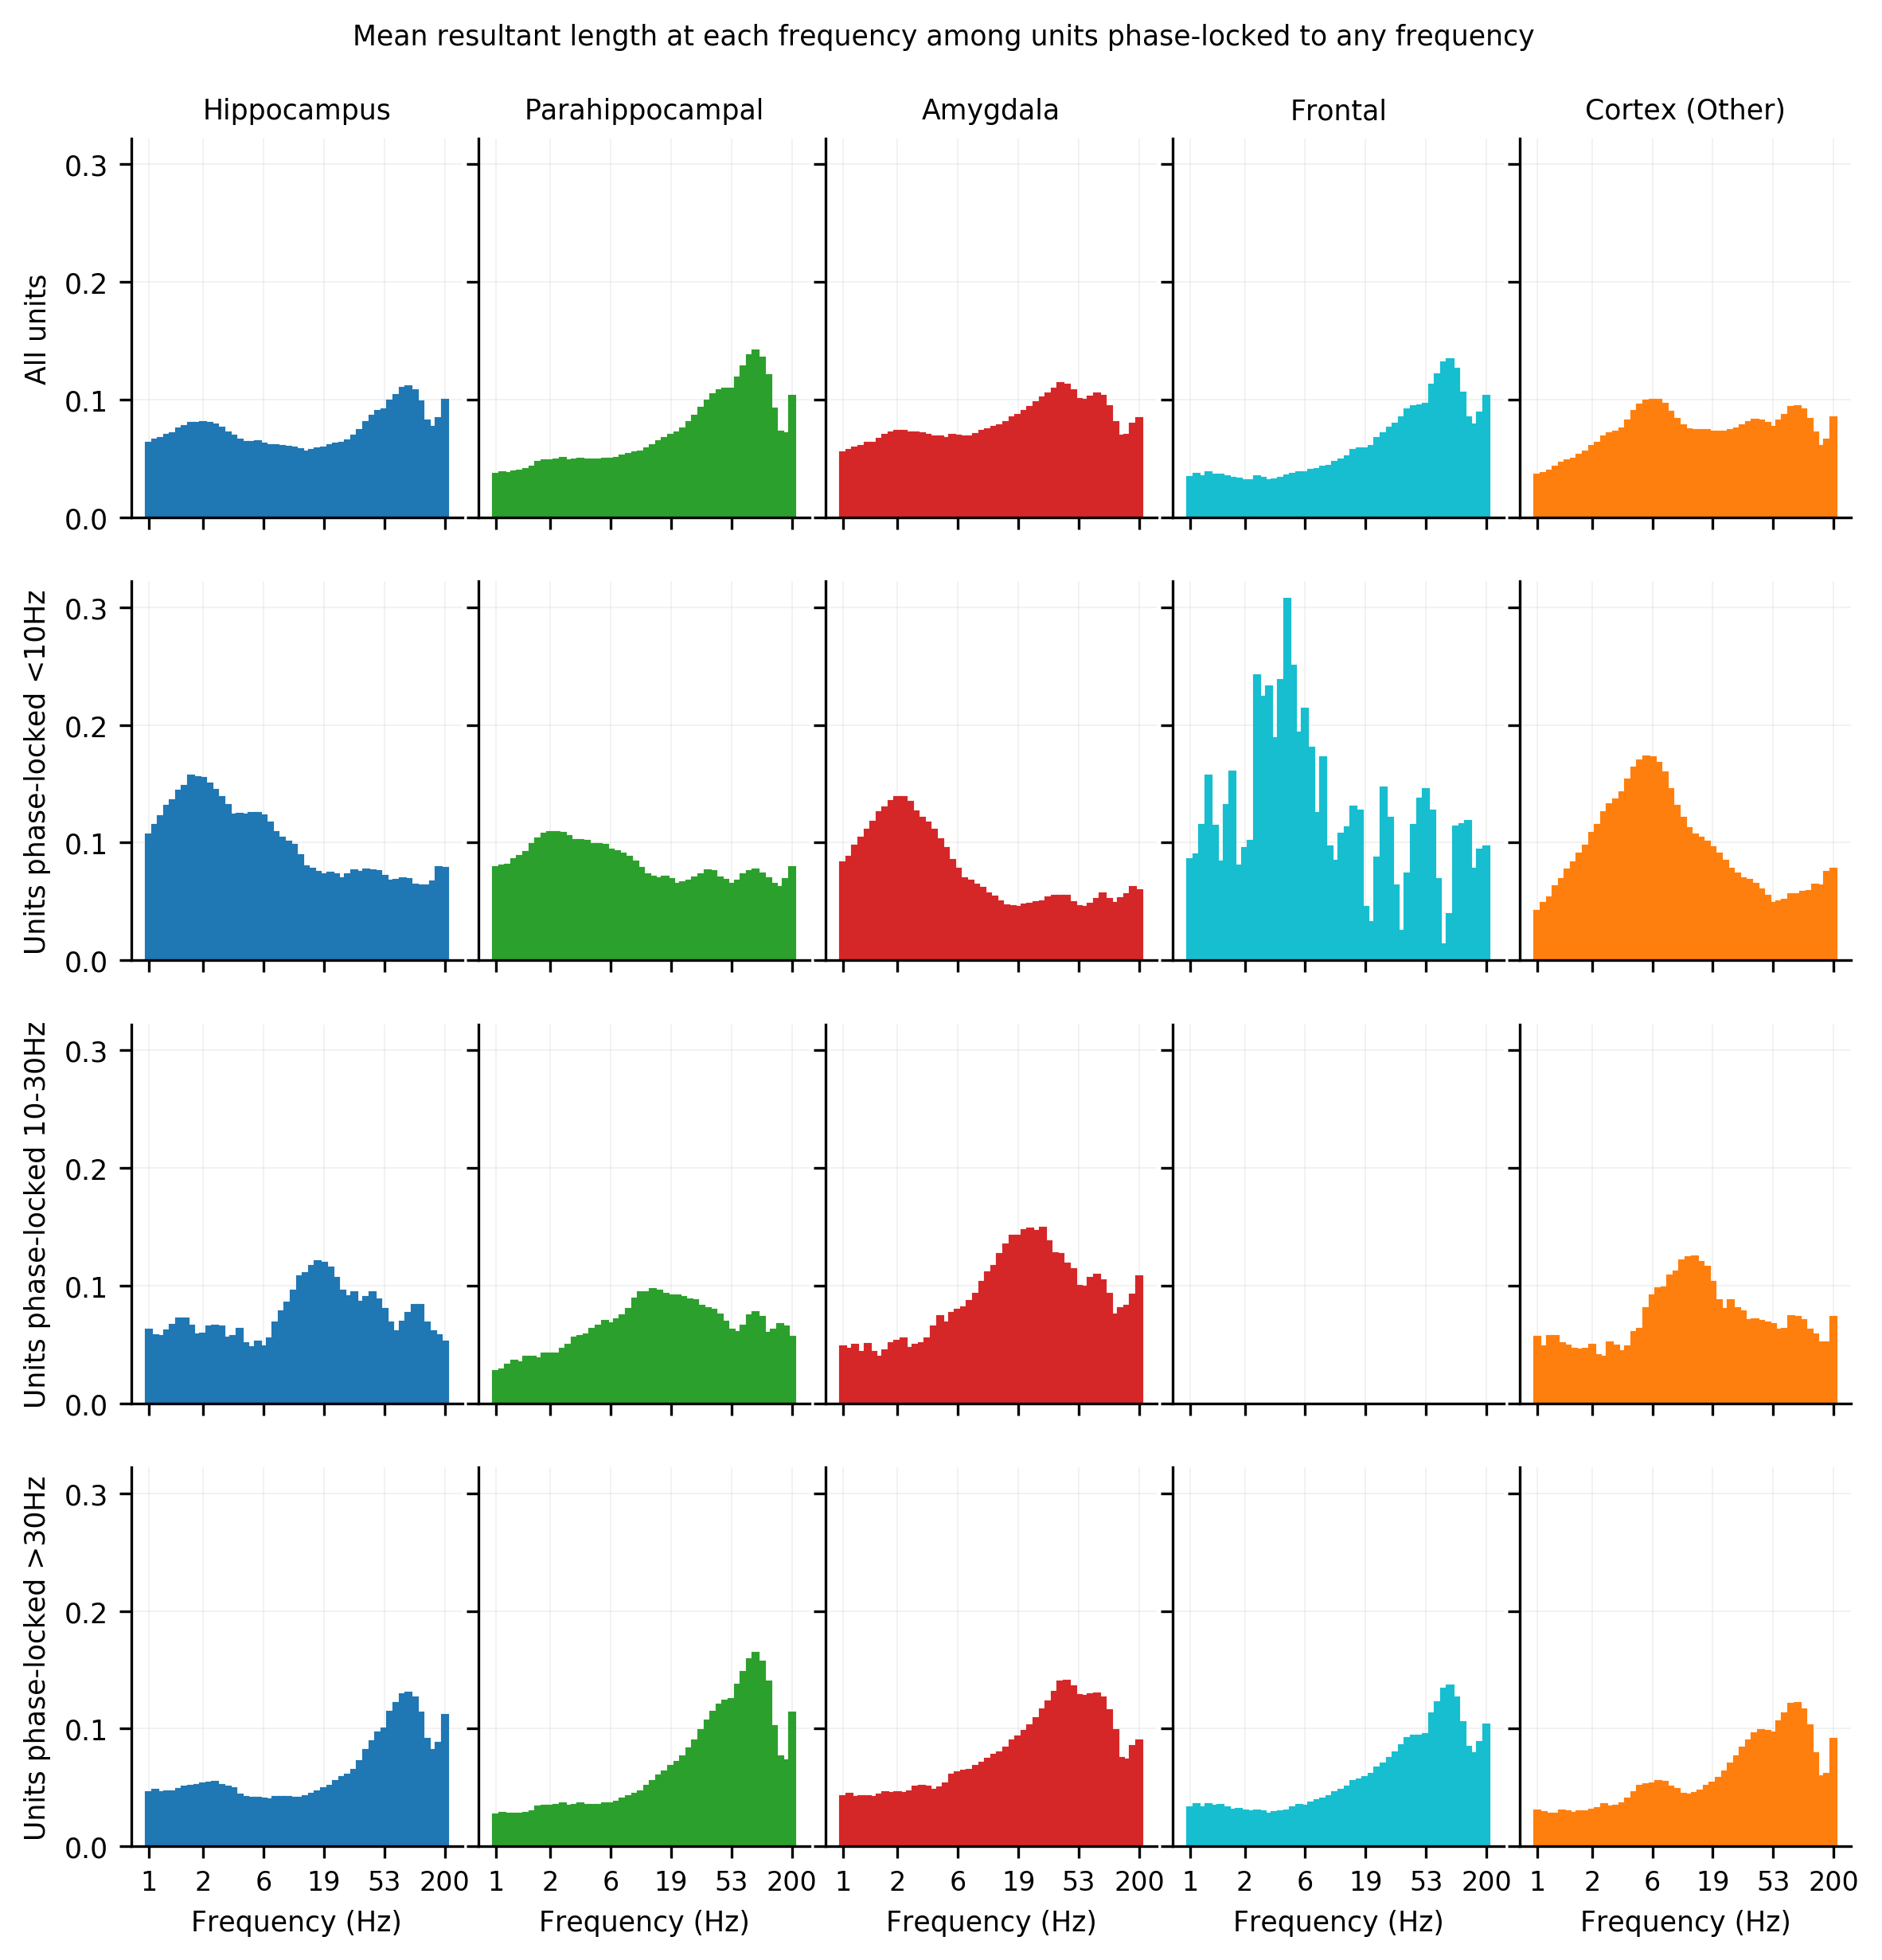

In [78]:
colors = ['C0', 'C2', 'C1', 'C9', 'C3']

fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

ylabels = ['All units', 'Units phase-locked <10Hz', 'Units phase-locked 10-30Hz', 'Units phase-locked >30Hz']

i = 0
for x in range(4):
    for j, roi in enumerate(rois):
        if len(counts3[x][roi]) > 0:
            ax[i].bar(np.arange(len(freqs)), np.array(list(counts3[x][roi].values())), 
                      color=colors[j], edgecolor=colors[j])
        ax[i].set_xticks(np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int))
        ax[i].set_xticklabels([int(round(f, 1)) for f in freqs[np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int)]], fontsize=8)
        if x == 3:
            ax[i].set_xlabel('Frequency (Hz)')
        if x == 0:
            ax[i].set_title(fancy_names[roi])
        if j == 0:
            ax[i].set_ylabel(ylabels[x])
        i += 1

fig.suptitle('Mean resultant length at each frequency among units phase-locked to any frequency', y=1.02)
fig.tight_layout(w_pad=0.05, h_pad=0.05)

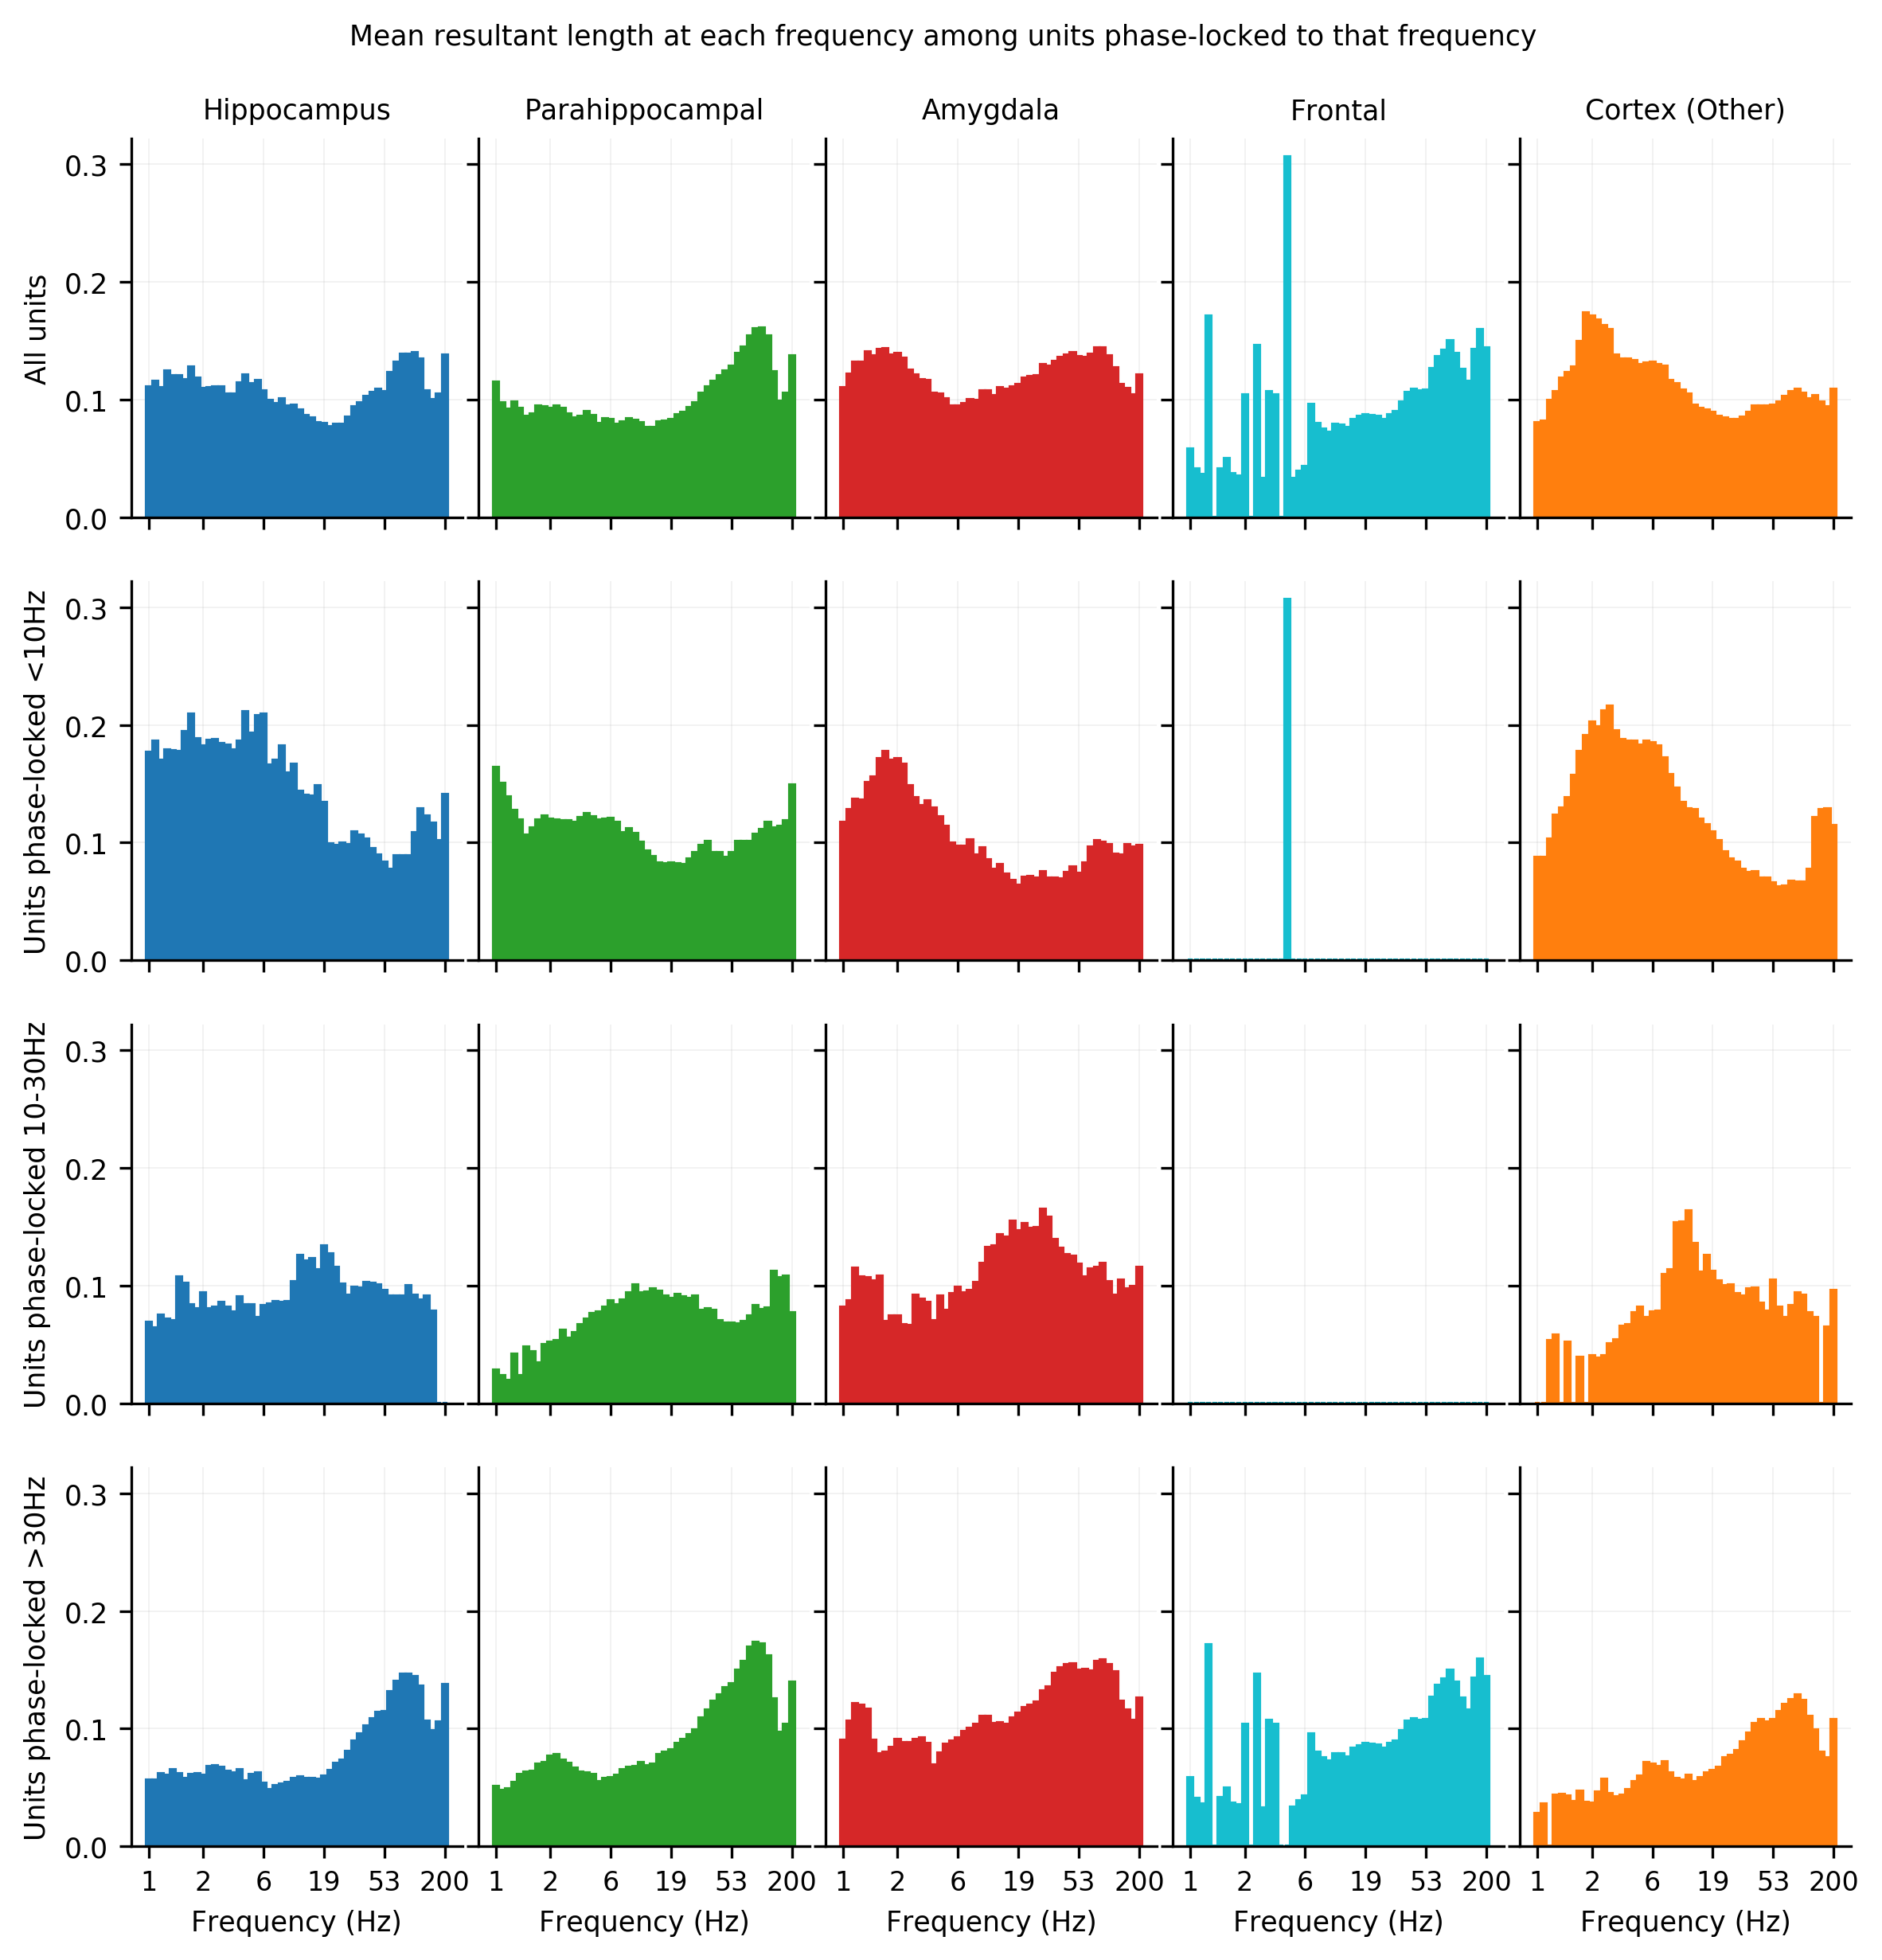

In [79]:
colors = ['C0', 'C2', 'C1', 'C9', 'C3']

fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(8, 8), dpi=300)
ax = np.ravel(ax)

ylabels = ['All units', 'Units phase-locked <10Hz', 'Units phase-locked 10-30Hz', 'Units phase-locked >30Hz']

i = 0
for x in range(4):
    for j, roi in enumerate(rois):
        ax[i].bar(np.arange(len(freqs)), np.array(list(counts2[x][roi].values())), 
                  color=colors[j], edgecolor=colors[j])
        ax[i].set_xticks(np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int))
        ax[i].set_xticklabels([int(round(f, 1)) for f in freqs[np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int)]], fontsize=8)
        if x == 3:
            ax[i].set_xlabel('Frequency (Hz)')
        if x == 0:
            ax[i].set_title(fancy_names[roi])
        if j == 0:
            ax[i].set_ylabel(ylabels[x])
        i += 1

fig.suptitle('Mean resultant length at each frequency among units phase-locked to that frequency', y=1.02)
fig.tight_layout(w_pad=0.05, h_pad=0.05)

Text(0.5,1,'Degree of modulation among phase-locked neurons')

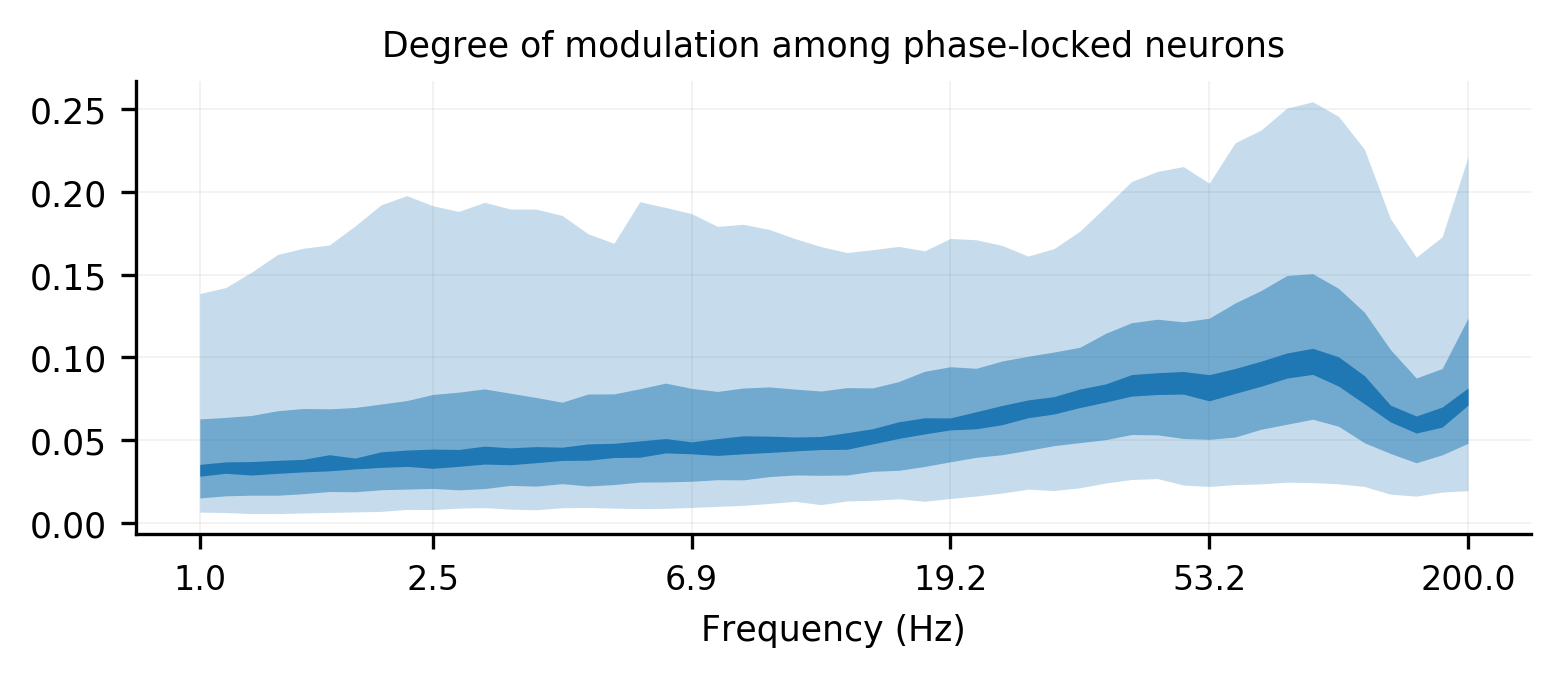

In [80]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6, 2), dpi=300)
ax = np.ravel(ax)

dat = np.array(pl_df.query("(sig==True) & (n_locked<{})".format(n_locked_thresh)).circmoms.tolist())
xvals = np.arange(dat.shape[1])

ax[0].fill_between(xvals, 
                   np.percentile(dat, 5, axis=0),
                   np.percentile(dat, 95, axis=0),
                   color='C0', alpha=0.25, linewidth=0, label='5-95%')
ax[0].fill_between(xvals, 
                   np.percentile(dat, 25, axis=0),
                   np.percentile(dat, 75, axis=0),
                   color='C0', alpha=0.5, linewidth=0, label='25-75%')
ax[0].fill_between(xvals, 
                   np.percentile(dat, 45, axis=0),
                   np.percentile(dat, 55, axis=0),
                   color='C0', alpha=1, linewidth=0, label='45-55%')
ax[0].set_xticks(np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int))
ax[0].set_xticklabels([round(f, 1) for f in freqs[np.linspace(0, len(freqs)-1, 6, endpoint=True, dtype=int)]], fontsize=8)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_title('Degree of modulation among phase-locked neurons')

## Older

In [558]:
# Calculate phase-locking values at selected frequencies, for each unit in the dataset.
#freqs = np.array([2**(x/8) for x in range(53)])
freqs = np.array([f for f in np.logspace(np.log10(1), np.log10(100), 52) if abs(60 - f) > 5])
n_bootstraps = 1000
col_names = ['subj_sess', 'unit', 'chan', 'hem', 'roi', 'hemroi', 'is_hpc', 'phases', 'mus', 'kappas', 'circmoms', 'pvals', 'pval_inds_1000']
hpc_rois = ['LAH', 'LMH', 'LPH', 'RAH', 'RMH', 'RPH']
interp_spikes = True
ms_before = 2
ms_after = 4
pow_thresh = 25
save_outputs = True

start_time = time()
freq_iter = range(len(freqs))
output = []
for subj_sess in sorted(spike_chans.keys()):
    # Load spikes.
    with open(os.path.join(data_dir, 'spikes', '{}_session_spikes.pkl'.format(subj_sess)), 'rb') as f:
        spikes = pickle.load(f)
    fr_df, clus_to_chan, chan_to_clus = manning_analysis.get_fr_df(subj_sess, spikes)
    units = fr_df.clus.tolist()
    
    # Load LFP
    #lfp = TimeSeries.from_hdf(os.path.join(data_dir, 'lfp', '{}_raw.hdf'.format(subj_sess)))
    lfp_raw, lfp_proc = manning_analysis.process_lfp(subj_sess, subj_df, interpolate=interp_spikes, 
                                                     session_spikes=spikes, ms_before=ms_before, ms_after=ms_after)
    
    print('Done loading LFP/spikes: {:.0f} secs'.format(time() - start_time))
    
    for unit in units:
        spike_train = fr_df.loc[unit, 'spikes']
        n_timepoints = len(spike_train)
        chan = fr_df.at[unit, 'chan']
        hemroi = fr_df.at[unit, 'location']
        hem = hemroi[0]
        roi = hemroi[1:]
        is_hpc = hemroi in hpc_rois
        lfp_chan = lfp_proc.sel(channel=[chan])
        
        # Get power and phase.
        power, phase = manning_analysis.run_morlet(lfp_chan, freqs=freqs, width=5, output=['power', 'phase'], 
                                                   log_power=True, z_power=True, savedir=False, verbose=True)
        power = power.squeeze()
        phase = phase.squeeze()
        phase_dat = phase.data
        
        # Get power values above the 25% for each freq.
        if pow_thresh > 0:
            power_mask = power.data > np.expand_dims(np.percentile(power, pow_thresh, axis=1), 1)
        else:
            power_mask = power.data >= np.expand_dims(np.percentile(power, pow_thresh, axis=1), 1)
        
        print('Got power/phase: {:.0f} secs'.format(time() - start_time))
        
        # Collect phases of spike times above power thresholds.        
        phases = []
        mus = []
        kappas = []
        pvals = []
        circmoms = []
        for ifreq in freq_iter:
            ifreq_phases = phase_dat[ifreq, np.flatnonzero(power_mask[ifreq, :] * spike_train)]
            phases.append(ifreq_phases)
            mu, kappa = circstats.vonmisesmle(ifreq_phases)
            mus.append(mu)
            kappas.append(kappa)
            circmoms.append(circstats.circmoment(ifreq_phases)[1])
            pvals.append(circstats.rayleightest(ifreq_phases))
        mus = np.array(mus)
        kappas = np.array(kappas)
        circmoms = np.array(circmoms)
        pvals = np.array(pvals)
        
        # Bootstrapping - Randomly shift the spike vector 1000x and recalc Rayleigh.
        bs_pvals = []
        for i in range(n_bootstraps):
            spike_train_shifted = np.roll(spike_train, 1+int(random.random()*n_timepoints-1))
            bs_pvals_ = []
            for ifreq in freq_iter:
                ifreq_phases = phase_dat[ifreq, np.flatnonzero(power_mask[ifreq, :] * spike_train_shifted)]
                bs_pvals_.append(circstats.rayleightest(ifreq_phases))
            bs_pvals.append(bs_pvals_)
        bs_pvals = np.array(bs_pvals) # bootstrap x freq
        pval_inds = np.sum(bs_pvals < pvals, axis=0)
            
#         # Bootstrapping - Randomly shift the spike vector 1000x and recalc Rayleigh.
#         pval_inds = []
#         for ifreq in range(len(freqs)):
#             bs_pvals = []
#             for i in range(n_bootstraps):
#                 spike_train_shifted = np.roll(spike_train, 1+int(random.random()*n_timepoints-1))
#                 ifreq_phases = phase_dat[ifreq, np.flatnonzero(power_mask[ifreq, :] * spike_train_shifted)]
#                 bs_pvals.append(circstats.rayleightest(ifreq_phases))
#             pval_inds.append(np.sum(np.array(bs_pvals) < pvals[ifreq]))
#         pval_inds = np.array(pval_inds)
        
        # Add values for the unit to the output list
        output.append([subj_sess, unit, chan, hem, roi, hemroi, is_hpc, phases, mus, kappas, circmoms, pvals, pval_inds])
        
    # Covert output list to DataFrame format.
    if interp_spikes:
        pl_df_interp = pd.DataFrame(output, columns=col_names)
    else:
        pl_df = pd.DataFrame(output, columns=col_names)

    # Save outputs.
    if save_outputs:
        if interp_spikes:
            fname = os.path.join(ccg_dir, 'data', 'phase_locking', 
                                 'local_phase_locking_df_pow{}mask_interp-{}_{}ms_{}.pkl'.format(pow_thresh, ms_before, ms_after, subj_sess))
            with open(fname, 'wb') as f:
                pickle.dump(pl_df_interp, f, pickle.HIGHEST_PROTOCOL)
            print('Saved pl_df_interp as {}'.format(fname))
        else:
            fname = os.path.join(ccg_dir, 'data', 'phase_locking', 
                                 'local_phase_locking_df_pow{}mask_nointerp_{}.pkl'.format(pow_thresh, subj_sess))
            with open(fname, 'wb') as f:
                pickle.dump(pl_df, f, pickle.HIGHEST_PROTOCOL)
            print('Saved pl_df as {}'.format(fname))
        
    break
    
print('Done in {:.0f} secs'.format(time() - start_time))

Done loading LFP/spikes: 26 secs
Calculating power and phase.
CPP total time wavelet loop:  11.209289073944092
Log-transforming power values.
Z-scoring power across time, within each frequency.
Got power/phase: 52 secs
Done in 108 secs


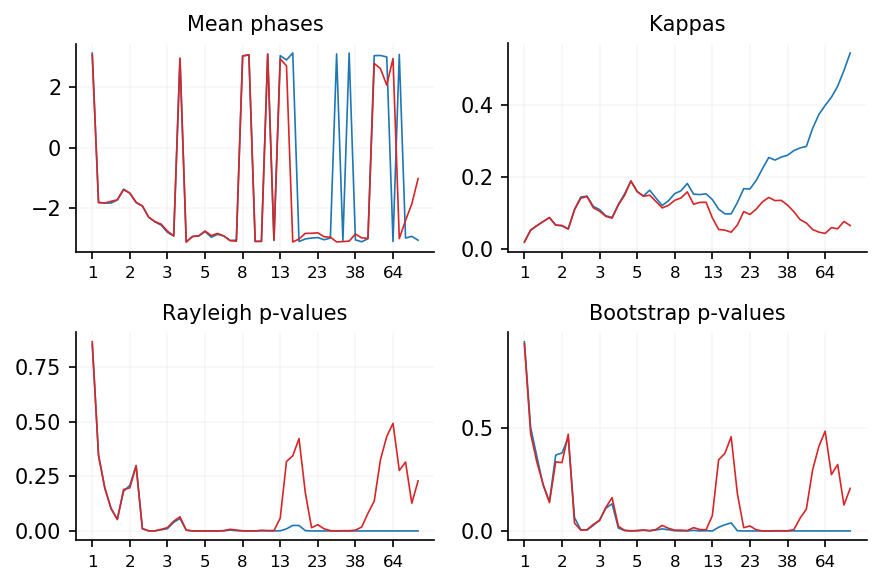

In [559]:
fig, ax = plt.subplots(2, 2)
ax = np.ravel(ax)
j = 0

ax[0].plot(pl_df.mus.iat[j])
ax[0].plot(pl_df_interp.mus.iat[j])
ax[0].set_title('Mean phases')

ax[1].plot(pl_df.kappas.iat[j])
ax[1].plot(pl_df_interp.kappas.iat[j])
ax[1].set_title('Kappas')

ax[2].plot(pl_df.pvals.iat[j])
ax[2].plot(pl_df_interp.pvals.iat[j])
ax[2].set_title('Rayleigh p-values')

ax[3].plot(pl_df.pval_inds_1000.iat[j] / 1000)
ax[3].plot(pl_df_interp.pval_inds_1000.iat[j] / 1000)
ax[3].set_title('Bootstrap p-values')

for i in range(4):
    ax[i].set_xticks(np.arange(0, len(freqs), 6))
    ax[i].set_xticklabels([int(round(x, 0)) for x in freqs[np.arange(0, len(freqs), 6)]], fontsize=8)

fig.tight_layout()

In [16]:
# chan = '1'
# freq_mean, P_mean = neurodsp.spectral.psd(lfp_raw.sel(channel=chan).data, 2000)
# freq_mean2, P_mean2 = neurodsp.spectral.psd(lfp_proc.sel(channel=chan).data, 2000)
# plt.figure(figsize=(6,3), dpi=150)
# plt.loglog(freq_mean[:200], P_mean[:200], alpha=0.6, linewidth=0.5, label='raw LFP')
# plt.loglog(freq_mean2[:200], P_mean2[:200], alpha=0.6, linewidth=0.5, label='LFP notch 58-62, 118-122, 178-182')
# plt.legend()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power (V^2/Hz)')
# plt.show()